In [77]:
import ROOT as root
from scipy.interpolate import CubicSpline
import numpy as np
import matplotlib.pyplot as plt

# Reactor neutrino spectrum generator

In this notebook I will write my own code, based on the reactorNuSpectrumGenerator code by schedges (Samuel Hedges), to generate reactor neutrino spectra for a given set of reactor properties

## Constants

In [2]:
GeV = 1
MeV = 1e-3*GeV
keV = 1e-6*GeV
eV = 1e-9*GeV
hbarc = 0.19732698 # GeV fm
speed_of_light = 2.997925e8 # m/s
Gf = 1.166378e-5/GeV**2
electron_charge = 1.60217663e-19 # coulombs
amu = 0.931494

METER = 1e15/hbarc
CENTIMETER = 1e-2*METER
SECOND = speed_of_light*METER
YEAR = 60*60*24*365.25*SECOND
JOULE = eV/electron_charge
GIGAWATT = 1e9*JOULE/SECOND
KILOGRAM = speed_of_light**2*JOULE
KILOGRAMDAY = KILOGRAM*(60*60*24*SECOND)
CM2S = CENTIMETER**2*SECOND

In [3]:
energy_per_fission_i = np.array([201.92, 205.52, 209.99, 213.60])*MeV

## Importing fluxes for each fissile isotope

### Importing the flux from 2304.14992 and outputting it to a text file

In [45]:
fissileIsotopeSpectraFile = root.TFile('./fluxData/BESTIOLE_2023.root')

In [46]:
fissile_isotopes_ROOT_format = ["235U", "238U", "239Pu", "241Pu"]
Enu_min, Enu_max, nbins = 0, 12.5, 500 # spectra go from 0 MeV to 12.5 MeV
bin_width = (Enu_max - Enu_min)/nbins
nu_energies_BESTIOLE = np.arange(bin_width/2, 12.5, bin_width) # Using the centre of each bin to locate the data point (so have data points between 0.0125 MeV and 12.4875 MeV)

In [47]:
fissionSpectra = fissileIsotopeSpectraFile.Get("fission")

fission_fluxes_BESTIOLE = []

for fissile_isotope in fissile_isotopes_ROOT_format:
    fission_fluxes_BESTIOLE.append([flux for flux in fissionSpectra.Get(f"{fissile_isotope}_nspec")][1:-1])

Text(0,0.5,'Rate (/fission/MeV)')

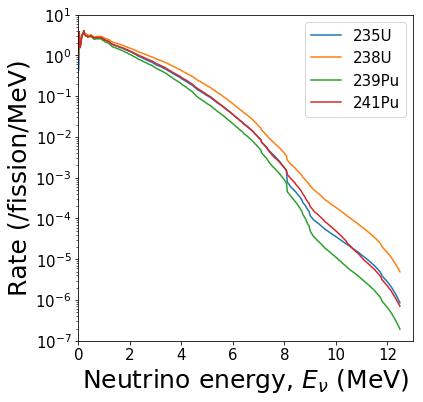

In [52]:
fig, ax = plt.subplots(figsize=(6,6))

for fission_flux, fi in zip(fission_fluxes_BESTIOLE, fissile_isotopes_ROOT_format):
    ax.plot(nu_energies_BESTIOLE, fission_flux, label=fi)

ax.legend(fontsize=15)

ax.set_yscale('log')
ax.set_xlim(0, 13)
ax.set_ylim(1e-7, 1e1)
ax.tick_params(labelsize=15)

ax.set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
ax.set_ylabel("Rate (/fission/MeV)", fontsize=25)

Export them to text files with the same format as those in /fluxData

In [40]:
fissile_isotopes_txtfile_format = ['u235', 'u238', 'pu239', 'pu241']

In [54]:
for fissile_isotope, fission_flux in zip(fissile_isotopes_txtfile_format, fission_fluxes_BESTIOLE):
    with open(f'./fluxData/bestiole_{fissile_isotope}.txt', 'w') as outFile:
        outFile.write('#Data from https://arxiv.org/abs/2304.14992 ancillary materials\n')
        for i, (energy, flux) in enumerate(zip(nu_energies_BESTIOLE, fission_flux)):
            line = f'{energy}, {flux}'
            if i != nbins - 1:
                line += '\n'
            outFile.write(line)

### Importing fluxes from text files and making interpolating functions

In [116]:
def get_spectrum(filename):
    energies = []
    fluxes = []

    for line in open(filename):
        if not line.startswith("#"):
            line=line.strip("\n")
            lineParts=line.split(",")
            energies.append(float(lineParts[0]))
            fluxes.append(float(lineParts[1]))
    
    return (np.array(energies)*MeV, np.array(fluxes)/MeV)

In [117]:
spectrum_source = 'bestiole'

fission_spectra_data = []
fission_spectra = []

for fi in fissile_isotopes_txtfile_format:
    spec = get_spectrum(f"fluxData/{spectrum_source}_{fi}.txt")
    fission_spectra_data.append(spec)

    fission_spectra.append(CubicSpline(*spec, extrapolate=False))


Text(0,0.5,'Rate (/fission/MeV)')

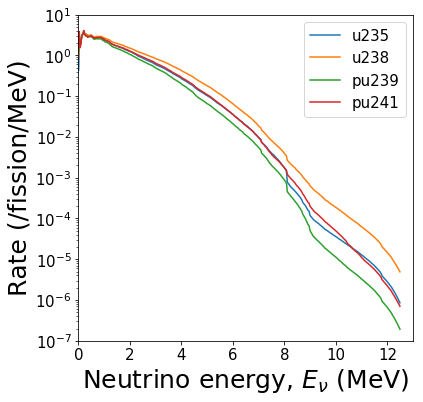

In [121]:
fig, ax = plt.subplots(figsize=(6,6))

for fi, spec_data in zip(fissile_isotopes_txtfile_format, fission_spectra_data):
    ax.plot(spec_data[0]/MeV, spec_data[1]*MeV, label=fi)

ax.legend(fontsize=15)

ax.set_yscale('log')
ax.set_xlim(0, 13)
ax.set_ylim(1e-7, 1e1)
ax.tick_params(labelsize=15)

ax.set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
ax.set_ylabel("Rate (/fission/MeV)", fontsize=25)

### Comparing the different fluxes

Text(0,0.5,'Rate (/fission/MeV)')

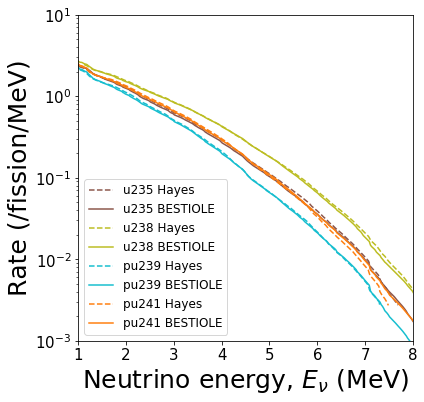

In [76]:
fig, ax = plt.subplots(figsize=(6,6))

for fi in fissile_isotopes_txtfile_format:
    hayes_spec_data = get_spectrum(f"fluxData/hayes_{fi}.txt")
    bestiole_spec_data = get_spectrum(f"fluxData/bestiole_{fi}.txt")

    ax.plot(*hayes_spec_data, f'C{fi[-1]}--', label=f'{fi} Hayes')
    ax.plot(*bestiole_spec_data, f'C{fi[-1]}', label=f'{fi} BESTIOLE')

ax.legend(fontsize=12)

ax.set_yscale('log')
ax.set_xlim(1, 8)
ax.set_ylim(1e-3, 1e1)
ax.tick_params(labelsize=15)

ax.set_xlabel(r"Neutrino energy, $E_\nu$ (MeV)", fontsize=25)
ax.set_ylabel("Rate (/fission/MeV)", fontsize=25)

## Making the spectrum

In [122]:
def reactor_flux(Enu, fuel_fractions, thermal_power):
    norm_fuel_fractions = np.array(fuel_fractions)/sum(fuel_fractions)

    mean_energy_per_fission = sum(norm_fuel_fractions*energy_per_fission_i)

    return (thermal_power/mean_energy_per_fission)*sum([fi*spec(Enu) for fi, spec in zip (norm_fuel_fractions, fission_spectra)])

In [124]:
reactor_flux(3*MeV, [1,0,0,0], 0.085*GIGAWATT)

0.001036814627122366